# Example Working Notebook

This notebook runs the example case for cmaqml. The options are defined in `config.json`, which includes many notes. This notebook is option agnostic. So, you can run with the default options or update them. If you disable Universal Kriging (thin_krig_dataset=0), the plotting here will not work.

In [1]:
%matplotlib inline

In [2]:
install_libs = False
if install_libs:
    !pip install cmaqml
    !pip install --user pseudonetcdf pycno

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import PseudoNetCDF as pnc
import pycno
import cmaqml
import cmaqml.testcase
import os, shutil

In [4]:
if not os.path.exists('input'):
    os.symlink(cmaqml.testcase.input.paths['input'], 'input')

os.makedirs('output', exist_ok=True)

In [5]:
if not os.path.exists('config.json'):
    shutil.copyfile(cmaqml.testcase.input.paths['config'], 'config.json')

In [6]:
ls config.json input/

config.json

input/:
config.json
daily_44201_20160715.zip
daily_88101_20160115.zip
dailyavg.LST.Y_24.2016fh.v531.108US2.01.nc
gpw_v4_une_atotpopbt_densy_108US2.IOAPI.nc
GRIDCRO2D.108US2.35L.160101.nc
GRIDDESC
make_test.py
O3_8HRMAX.LST.Y_24.2016fh.v531.108US2.5-9.nc


In [7]:
outpaths = cmaqml.driver.run('config.json', verbose=1, validate=0)

input/O3_8HRMAX.LST.Y_24.2016fh.v531.108US2.5-9.nc 2016-07-15 00:00:00
input/O3_8HRMAX.LST.Y_24.2016fh.v531.108US2.5-9.nc
Retaining latitude
Retaining longitude
Retaining Y
Retaining X
ALL
Obs shape (1284, 40)
O mean: 45.00
prep 0.4 seconds
Model fit 0.0 seconds
Model point mean: 44.68
Model grid mean: 36.16
Model predict 0.0 seconds
Init UK...
Exec UK...
Krig 20.6 seconds
UnivKrig pnt mean: 44.90
UK err at grid mean: 0.0467114039815865
UK out at grid mean: 36.35346343687771
Save...
Total 22.2 seconds


In [8]:
outpaths

{'ALL': ['output/UK.20160715.ALL.prod.nc']}

In [9]:
allpath = outpaths['ALL'][0]

In [10]:
allf = pnc.pncopen(allpath, format='ioapi')
cno = pycno.cno(proj=allf.getproj(withgrid=True))

/home/bhenders/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  del sys.path[0]
/home/bhenders/.local/lib/python3.6/site-packages/ipykernel_launcher.py:33: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


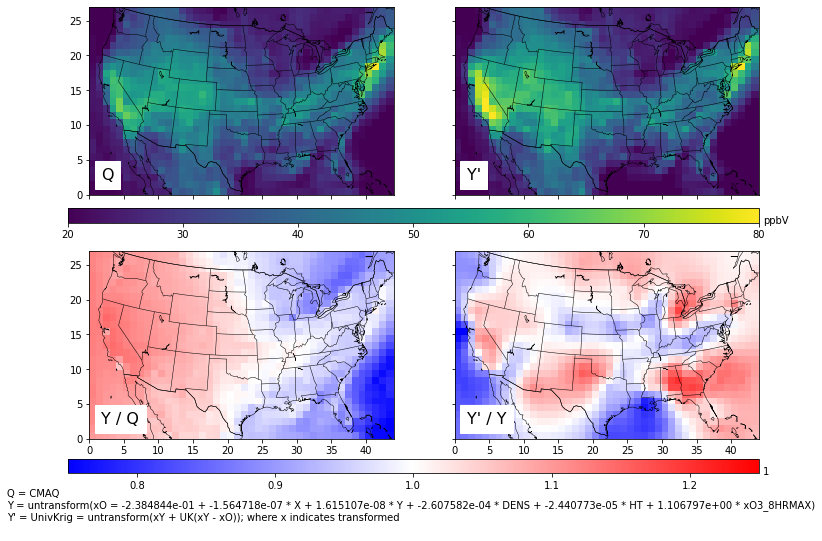

In [11]:
norm = plt.matplotlib.colors.LogNorm(vmax=10)
norm = plt.matplotlib.colors.Normalize(vmin=20, vmax=80)
dnorm = plt.matplotlib.colors.Normalize(vmin=.75, vmax=1.25)

fig, axx = plt.subplots(
    2, 2, figsize=(12, 8), sharex=True, sharey=True,
    gridspec_kw=dict(bottom=0.175, hspace=0.3, top=0.925)
)

dax = fig.add_axes([.1, .115, .8, .025])
cax = fig.add_axes([.1, .55, .8, .025])
cax.yaxis.set_label_position("right")
cax.set_ylabel(allf.variables['Q'].units.strip(), rotation=0, horizontalalignment='left')
dax.yaxis.set_label_position("right")
dax.set_ylabel('1', rotation=0, horizontalalignment='left')

p = axx[0, 0].pcolormesh(allf.variables['Q'][0, 0], norm=norm)
p = axx[0, 1].pcolormesh(allf.variables['UK_TOTAL'][0, 0], norm=norm)
fig.colorbar(p, orientation='horizontal', cax=cax)

p = axx[1, 0].pcolormesh(allf.variables['Y'][0, 0] / allf.variables['Q'][0, 0], norm=dnorm, cmap='bwr')
p = axx[1, 1].pcolormesh(allf.variables['UK_TOTAL'][0, 0] / allf.variables['Y'][0, 0], norm=dnorm, cmap='bwr')
fig.colorbar(p, orientation='horizontal', cax=dax)

titles = ['Q', 'Y\'', 'Y / Q', 'Y\' / Y']
for ax, title in zip(axx.ravel(), titles):
    ax.text(0.04, 0.08, title, transform=ax.transAxes, backgroundcolor='white', size=16)
    cno.draw('MWDB_Coasts_USA_3.cnob', ax=ax)

footer = f"""Q = CMAQ
Y = {allf.variables['Y'].var_desc}
Y\' = {allf.variables['UK_TOTAL'].var_desc}
"""
fig.text(0.03, 0.01, footer, verticalalignment='bottom');


# Perform Validation Run

In [12]:
validate = 1

In [13]:
cfg = cmaqml.opts.loadcfg('config.json')
for qkey in list(cfg['query_definitions']):
    if qkey != 'ALL':
        cfg['query_definitions'].pop(qkey)

In [14]:
validatepaths = cmaqml.driver.run(cfg, verbose=2, validate=validate)

(1156, 37)
input/O3_8HRMAX.LST.Y_24.2016fh.v531.108US2.5-9.nc 2016-07-15 00:00:00
input/O3_8HRMAX.LST.Y_24.2016fh.v531.108US2.5-9.nc
Retaining latitude
Retaining longitude
Retaining Y
Retaining X
ALL
Obs shape (1156, 40)
O mean: 44.87
prep 0.0 seconds
Model fit 0.0 seconds
Model point mean: 44.54
Model grid mean: 36.18
Model predict 0.0 seconds
Init UK...
Exec UK...
Krig 14.2 seconds
UnivKrig pnt mean: 44.64
UK err at grid mean: 0.04101792596290191
UK out at grid mean: 36.0290837080748
Save...
Total 15.1 seconds


In [15]:
validatepaths

{'ALL': ['output/UK.20160715.ALL.test01.nc']}

In [16]:
valf = pnc.pncopen(validatepaths['ALL'][0], format='ioapi')

In [17]:
cfg = cmaqml.opts.loadcfg('config.json')
obsdf = cmaqml.obs.loadobs(cfg['obs'], valf, [])
subsets = cmaqml.obs.train_and_testdfs(obsdf, None, validate)
testdf = subsets['test']
traindf = subsets['train']

In [18]:
if 'UK_TOTAL' in valf.variables:
    outkey = 'UK_TOTAL'
else:
    outkey = 'Y'

In [19]:
testdf['TEST'] = valf.variables[outkey][0, 0][testdf.J, testdf.I]

In [20]:
traindf['TRAIN'] = valf.variables[outkey][0, 0][traindf.J, traindf.I]

In [21]:
teststatdf = testdf.loc[:, ['TEST', 'O']].eval('BIAS = TEST - O').eval('ERR = abs(BIAS)').mean()
teststatdf['R'] = testdf.loc[:, ['TEST', 'O']].corr().loc['TEST', 'O']
teststatdf['RMSE'] = ((testdf.loc[:, 'TEST'] - testdf.loc[:, 'O'])**2).mean()**.5
teststatdf['NMB'] = teststatdf['BIAS'] / teststatdf['O'] * 100

In [22]:
trainstatdf = traindf.loc[:, ['TRAIN', 'O']].eval('BIAS = TRAIN - O').eval('ERR = abs(BIAS)').mean()
trainstatdf['R'] = traindf.loc[:, ['TRAIN', 'O']].corr().loc['TRAIN', 'O']
trainstatdf['RMSE'] = ((traindf.loc[:, 'TRAIN'] - traindf.loc[:, 'O'])**2).mean()**.5
trainstatdf['NMB'] = trainstatdf['BIAS'] / trainstatdf['O'] * 100

In [23]:
pd.concat([trainstatdf, teststatdf], keys=['train', 'test']).unstack(1).round(2)

,BIAS,ERR,NMB,O,R,RMSE,TEST,TRAIN
train,-0.26,4.69,-0.59,44.87,0.90,6.75,NaN,44.6
test,-0.68,5.37,-1.47,46.25,0.89,7.40,45.57,NaN
